In [1]:
# load the relevant modules for the analysis

import os
from pathlib import Path

import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pl_temp_fit import Exp_data_utils, config_utils

sns.set_theme(
    context="notebook",
    style="white",
    palette="deep",
    font="sans-serif",
    font_scale=0.6,
    color_codes=True,
    rc=None,
)

os.chdir("..")
# access the right directory


In [2]:
databse_path = Path("fit_experimental_emcee_pl/fit_data_base/sensitivity")
add_for_ssh = ""
json_files = list(databse_path.glob("*.json"))
list_model_config = []
for _id, json_file in enumerate(json_files):
    model_config, model_config_save = config_utils.load_model_config(
        json_file.name.replace(".json", ""),
        database_folder=databse_path,
    )
    if os.path.exists(
        add_for_ssh + model_config_save["save_folder"] + "/sampler.h5"
    ):
        filename = (
            add_for_ssh + model_config_save["save_folder"] + "/sampler.h5"
        )
        try:
            reader = emcee.backends.HDFBackend(filename, name="multi_core")
            if not reader.initialized:
                print("multi_core empty file")
                continue
            if reader.iteration == 0:
                print("empty file")
                continue
            distribution = reader.get_chain(flat=True)
        except AttributeError:
            print("check if single core")

            reader = emcee.backends.HDFBackend(filename, name="single_core")
            if not reader.initialized:
                print("empty file")
                continue
            distribution = reader.get_chain(flat=True)

        true_parameters = list(np.mean(distribution, axis=0))
        model_config_save["mean"] = [f"{x:.3f}" for x in true_parameters]
        model_config_save["num_iteration"] = reader.iteration
        log_prob = reader.get_log_prob(flat=True)
        model_config_save["max_log_prob"] = np.max(log_prob)
        list_model_config.append(model_config_save)
if len(list_model_config) == 0:
    print("no data")
else:
    df_all = pd.DataFrame(list_model_config)
    df_all.sort_values(by="date", ascending=False, inplace=True)
df_all["csv_name_pl"] = df_all["csv_name_pl"].apply(lambda x: x.split("/")[-1])
df_all[["csv_name_pl", "num_iteration", "max_log_prob"]]

,csv_name_pl,num_iteration,max_log_prob
0,ITIC-300K-2_G0_650.0nm_1450.0nm_12-07-2024-10h...,586,-531.554313
1,ITIC-300K-2_G0_650.0nm_1450.0nm_12-07-2024-10h...,5226,-476.237118


In [3]:
filename  = "/run/user/1000/gvfs/sftp:host=lcmdlc3.epfl.ch,user=mazzouzi/home/mazzouzi/pl_temp_fit/fit_experimental_emcee_pl/fit_data/{config_folder}/ITIC-300K-2_G0_650.0nm_1450.0nm_12-07-2024-10h-44m_Exposure_3.0s_mod_split0_split500_mod_split0_split500/new_pl_sampling_alllifetimes_abs/75c634bf-52c7-4425-9d14-f8af1866b174"

filename = filename+ "/sampler.h5"
reader = emcee.backends.HDFBackend(filename, name="multi_core")
distribution = reader.get_chain(discard=0, flat=True)

In [22]:
from pl_temp_fit import covariance_utils, fit_pl_utils, generate_data_utils


def generate_color_list(num_colors):
    """Generate a list of colors using a colormap.

    Parameters
    ----------
    num_colors (int): The number of colors needed.

    Returns
    -------
    list: A list of color codes.

    """
    cmap = plt.get_cmap("plasma")
    num_colors = num_colors + 3
    color_list = [cmap(i / num_colors) for i in range(num_colors)]
    return color_list


def plot_mean_and_variance(
    ax,
    co_var_mat_test,
    variance,
    hws,
    temperature_list,
    true_model_pl_list,
):
    """Plot the mean and variance of the data

    Arguments:
    ---------
        ax {matplotlib axis} -- axis to plot the data
        co_var_mat_test {np.array} -- covariance matrix of the data
        variance {np.array} -- variance of the data
        hws {np.array} -- photon energies
        temperature_list {np.array} -- temperatures
        true_model_pl_list {np.array} -- true model data

    Returns:
    -------
        np.array -- covariance matrix of the data

    """
    mean_value_plot = np.mean(np.array(true_model_pl_list), axis=0)
    print(f"shape of mean value plot is {mean_value_plot.shape}")
    color_list = generate_color_list(len(temperature_list))
    # plot the generated data
    for i in range(len(temperature_list)):
        ax.plot(
            hws,
            mean_value_plot[:, i],
            label="true" + str(temperature_list[i]) + " K",
            linestyle="--",
            color=color_list[i],
        )
        # plot using the covariance matrix
        ax.fill_between(
            hws,
            np.mean(np.array(true_model_pl_list), axis=0)[:, i]
            - np.sqrt(variance[:, i]) / 2,
            np.mean(np.array(true_model_pl_list), axis=0)[:, i]
            + np.sqrt(variance[:, i]) / 2,
            alpha=0.3,
            color=color_list[i],
        )
        ax.set_xlabel("Photon Energy (eV)", fontsize=15)
        ax.set_ylabel("PL Intensity (arb. units)", fontsize=15)
    return co_var_mat_test


def get_variance(point, covariance_matrix):
    """Calculate the variance of a point using the covariance matrix.

    Parameters
    ----------
    point (numpy array): The point for which to calculate the variance.
    covariance_matrix (numpy array): The covariance matrix.

    Returns
    -------
    float: The variance of the point.

    """
    point = np.array(point)
    covariance_matrix = np.array(covariance_matrix)

    variance = point.T @ covariance_matrix @ point
    return variance


def plot_generated_data_pl(
    save_folder,
    model_config,
    savefig=True,
    params_to_fit={},
    fixed_parameters_dict={},
    numnber_of_samples=20,
):
    """Plot the generated data

    Args:
    ----
        temperature_list_el {np.array} -- temperatures for EL
        hws_el {np.array} -- photon energies for EL
        temperature_list_pl {np.array} -- temperatures for PL
        hws_pl {np.array} -- photon energies for PL
        save_folder {str} -- folder to save the data
        model_config {dict} -- model configuration
        params_to_fit {dict} -- parameters to fit in the model
        fixed_parameters_dict {dict} -- fixed parameters for the model
    Keyword Arguments:
        savefig {bool} -- save the figure (default: {True})
        true_parameters {dict} -- true parameters for the model (default: {None})

    """
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    true_model_pl_list = []
    true_model_el_list = []
    print(f"params to fit are {params_to_fit}")
    for x in range(numnber_of_samples):
        model_data_pl, EX_kr, Ex_knr = generate_data_utils.generate_data_pl(
            **model_config,
            params_to_fit=params_to_fit,
            fixed_parameters_dict=fixed_parameters_dict,
        )
        true_model_pl_list = covariance_utils.add_data_list(
            true_model_pl_list,
            model_data_pl,
            model_config["hws_pl"],
            model_config["temperature_list_pl"],
        )

    co_var_mat_test_pl, variance_pl = covariance_utils.get_covariance_matrix(
        true_model_pl_list, numnber_of_samples, model_config
    )
    co_var_mat_test_pl = plot_mean_and_variance(
        ax,
        co_var_mat_test_pl,
        variance_pl,
        model_config["hws_pl"],
        model_config["temperature_list_pl"],
        true_model_pl_list,
    )
    # plot the generated data
    if savefig:
        import os

        os.makedirs(save_folder, exist_ok=True)
        fig.savefig(save_folder + "/generated_data.png")
    fig.tight_layout()
    return fig


def plot_fit_to_experimental_data(
    model_config_save,
    model_config,
    reader,
    discard=10,
    chains_list=None,
    filter_log_likelihood="",
):
    """Plot the fit to the experimental data
    model_config_save: the model config save dictionary
    model_config: the model config dictionary
    reader: the reader object from the emcee sampler
    discard: the number of samples to discard
    chains_list: the list of chains to plot
    """
    Temp_std_err = model_config_save["Temp_std_err"]
    hws_std_err = model_config_save["hws_std_err"]
    relative_intensity_std_error_pl = model_config_save[
        "relative_intensity_std_error_pl"
    ]
    noise_sigma = model_config_save["noise_sigma"]
    save_folder = model_config_save["save_folder"]
    fixed_parameters_dict = model_config_save["fixed_parameters_dict"]
    params_to_fit_init = model_config_save["params_to_fit_init"]
    min_bounds = model_config_save["min_bounds"]
    max_bounds = model_config_save["max_bounds"]
    csv_name = model_config_save["csv_name_pl"]
    Exp_data, temperature_list, hws = Exp_data_utils.read_data(csv_name)

    true_parameters = fit_pl_utils.get_param_dict(
        params_to_fit_init, distribution[-1]
    )  # model_config_save['params_to_fit_init']#
    fig = plot_generated_data_pl(
        save_folder,
        model_config,
        savefig=True,
        fixed_parameters_dict=fixed_parameters_dict,
        params_to_fit=true_parameters,
    )
    return fig


params to fit are {'EX': {'E': np.float64(1.7244614980187334), 'sigma': np.float64(0.04738704125728315), 'Li': np.float64(0.10144237611472236), 'Lo': np.float64(0.11892453507440208), 'hO': np.float64(0.1746231190663199)}, 'CT': {}, 'D': {}}
shape of mean value plot is (67, 7)


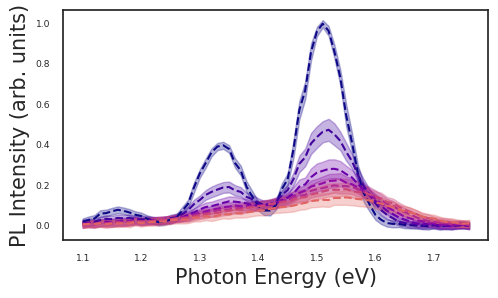

In [26]:
filter_log_likelihood = True
test_id= "3c77dd16-27b9-483d-bd7e-1e19bf767c26"
model_config, model_config_save = config_utils.load_model_config(
    test_id,
    database_folder=databse_path,
)
model_config_save["csv_name_pl"] = (
     model_config_save["csv_name_pl"]
)
fig = plot_fit_to_experimental_data(
    model_config_save,
    model_config,
    None,
    discard=0,
    filter_log_likelihood=filter_log_likelihood,
)
# save figure to svg
fig.savefig("notebook/figures/experimental_pL_spectra.svg")

In [27]:
# save figure to svg
fig.savefig("notebook/figures/experimental_pL_spectra.svg")

In [28]:
model_config_save

{'Temp_std_err': 10,
 'hws_std_err': 0.005,
 'relative_intensity_std_error_pl': 0.05,
 'relative_intensity_std_error_el': 0.001,
 'noise_sigma': 0.001,
 'save_folder': '/media/mohammed/Work/pl_temp_fit/fit_experimental_emcee_pl/fit_data/sensitivity/ITIC-300K-2_G0_650/3c77dd16-27b9-483d-bd7e-1e19bf767c26',
 'csv_name_pl': '/media/mohammed/Work/pl_temp_fit/dat_hanbo_311024/csv/ITIC-300K-2_G0_650.0nm_1450.0nm_12-07-2024-10h-44m_Exposure_3.0s_mod_split0_split500_mod_split0_split500.csv',
 'csv_name_el': '',
 'date': '2024_11_11',
 'test_id': '3c77dd16-27b9-483d-bd7e-1e19bf767c26',
 'fixed_parameters_dict': {'EX': {'numbrstates': 20, 'disorder_ext': 0.1},
  'CT': {'off': 1},
  'D': {}},
 'params_to_fit_init': {'EX': {'E': 1.7,
   'sigma': 0.04,
   'Li': 0.078,
   'Lo': 0.11,
   'hO': 0.159},
  'CT': {},
  'D': {}},
 'min_bounds': {'EX': {'E': 1.5,
   'sigma': 0.001,
   'Li': 0.03,
   'Lo': 0.03,
   'hO': 0.1},
  'CT': {},
  'D': {}},
 'max_bounds': {'EX': {'E': 1.9,
   'sigma': 0.1,
   'Li'

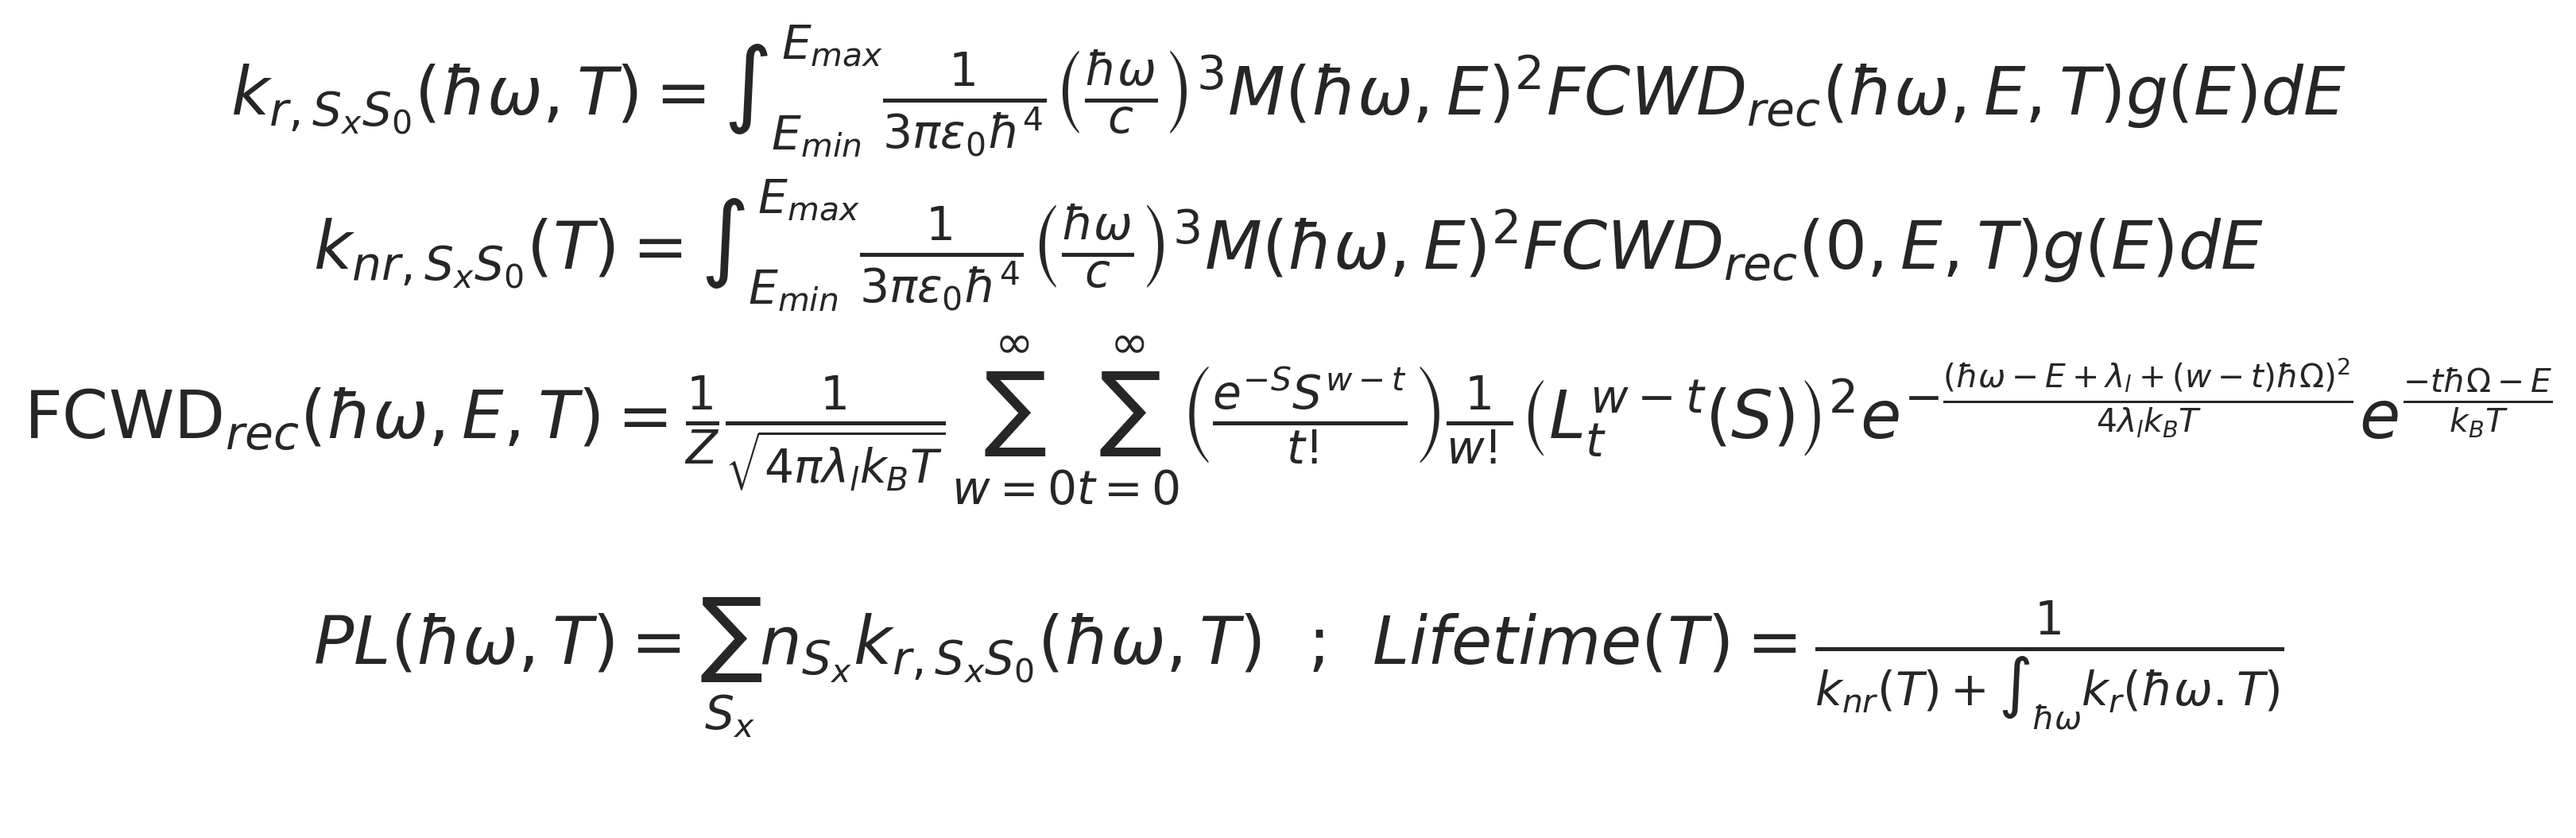

In [ ]:
# Define the mathematical expression
expression = (
    r"$k_{r,S_xS_0} (\hbar\omega, T)=\int_{E_{min}}^{E_{max}} \frac{1}{3\pi\epsilon_0 \hbar^4} \left(\frac{\hbar\omega}{c}\right)^3 M(\hbar\omega,E)^2 FCWD_{rec} (\hbar\omega,E,T) g(E) dE$"
    + "\n"
)
expression = (
    expression
    + r"$k_{nr,S_xS_0} ( T)=\int_{E_{min}}^{E_{max}} \frac{1}{3\pi\epsilon_0 \hbar^4} \left(\frac{\hbar\omega}{c}\right)^3 M(\hbar\omega,E)^2 FCWD_{rec} (0,E,T) g(E) dE$"
    + "\n"
)

expression = (
    expression
    + r"$\text{FCWD}_{rec} (\hbar\omega,E,T )=\frac{1}{Z} \frac{1}{\sqrt{4\pi\lambda_l k_B T}} \sum_{w=0}^{\infty} \sum_{t=0}^{\infty} \left(\frac{e^{-S} S^{w-t}}{t!}\right) \frac{1}{w!} \left(L_t^{w-t} (S)\right)^2 e^{-\frac{(\hbar\omega-E+\lambda_l+(w-t)\hbar\Omega)^2}{4\lambda_l k_B T}} e^{\frac{-t\hbar\Omega-E}{k_B T}}$"
    + "\n\n "
)
expression = (
    expression
    + r"$PL(\hbar\omega,T)=\sum_{S_x} n_{S_x} k_{r,S_xS_0} (\hbar\omega,T)$  ;  "
    + r"$Lifetime(T) = \frac{1}{k_{nr} ( T)+ \int_{\hbar\omega} k_r (\hbar\omega. T)}$"
    + "\n"
)
# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 3), dpi=300)

# Hide the axes
ax.axis("off")

# Add the mathematical expression to the plot
ax.text(0.5, 0.5, expression, fontsize=20, ha="center", va="center")

# Save the figure as an SVG file with high resolution
plt.savefig(
    "notebook/figures/high_res_math_expression.svg",
    format="svg",
    bbox_inches="tight",
)

# Show the plot
plt.show()


In [31]:
import pandas as pd

data = model_config_save["temperature_lifetimes_exp"]
df = pd.DataFrame(data, columns=["Temperature (K)", "Lifetime (ns)"])
df["Temperature (K)"] = data.keys()
df["Lifetime (ns)"] = data.values()
df["Temperature (K)"] = df["Temperature (K)"].astype(float)
df["Lifetime (ns)"] = df["Lifetime (ns)"].apply(lambda x: x * 1e9)
df["Error (ns)"] = df["Lifetime (ns)"] * 0.05
df.to_csv("notebook/figures/lifetime_data.csv", index=False)

Predicted mean log-likelihood at x=1.5: -0.020245644952124664
Standard deviation at x=1.5: 31.62277660168379
(4, 24) (4, 24)


/media/mohammed/Work/anaconda3/envs/pl_temp_fit/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/media/mohammed/Work/anaconda3/envs/pl_temp_fit/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


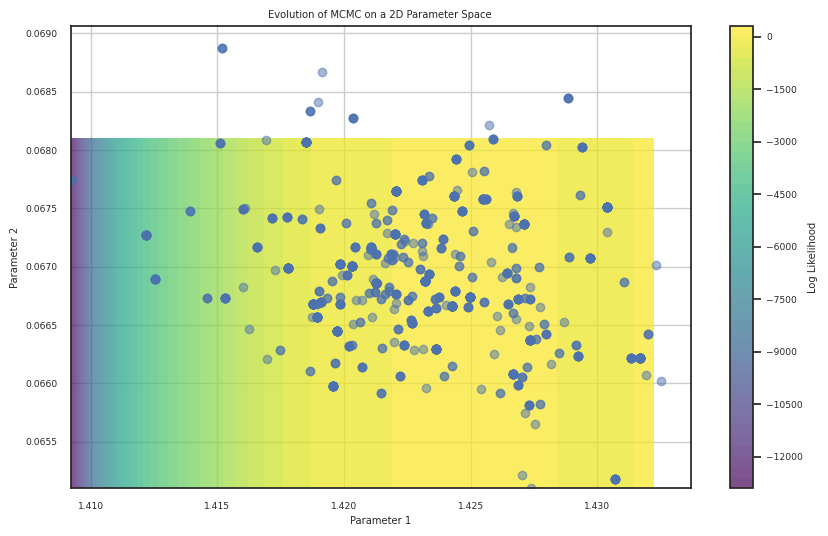

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C

log_likelihood = reader.get_log_prob(flat=True)
distribution = reader.get_chain(discard=500, flat=True)
# Generate samples using MCMC
num_samples = np.random.randint(len(distribution), size=500)
proposal_width = 0.5
samples = distribution[num_samples]
properties_to_plt = (0, 2)
# Example data
x_values = np.array(
    [samples[:, properties_to_plt[0]], samples[:, properties_to_plt[1]]]
).T
y_values = log_likelihood[num_samples]

# Define the kernel: ConstantKernel * RBF
kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))

# Create GaussianProcessRegressor object
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit to the data
gp.fit(x_values, y_values)

# Predict the mean value at any point
x_point = np.array([[1.5, 0.1]])
y_pred, sigma = gp.predict(x_point, return_std=True)

print(f"Predicted mean log-likelihood at x={x_point[0][0]}: {y_pred[0]}")
print(f"Standard deviation at x={x_point[0][0]}: {sigma[0]}")

import matplotlib.pyplot as plt
import numpy as np

# Define the target distribution (a simple 2D Gaussian)


def target_distribution(x, y):
    X_ = np.array([x, y]).reshape(-1, 2)
    return gp.predict(X_, return_std=True)[0]


# Metropolis-Hastings MCMC
def metropolis_hastings(num_samples, proposal_width):
    samples = np.zeros((num_samples, 2))
    x, y = 0, 0  # Start at the origin
    for i in range(num_samples):
        x_new = x + np.random.normal(0, proposal_width)
        y_new = y + np.random.normal(0, proposal_width)
        acceptance_ratio = target_distribution(
            x_new, y_new
        ) / target_distribution(x, y)
        if np.random.rand() < acceptance_ratio:
            x, y = x_new, y_new
        samples[i] = [x, y]
    return samples


# Generate samples using MCMC
num_samples = np.random.randint(len(distribution), size=1000)
proposal_width = 0.5
samples = distribution[num_samples]

# Create a grid of points for the background
x = np.arange(
    min(samples[:, properties_to_plt[0]]),
    max(samples[:, properties_to_plt[0]]),
    0.001,
)
y = np.arange(
    min(samples[:, properties_to_plt[1]]),
    max(samples[:, properties_to_plt[1]]),
    0.001,
)
X, Y = np.meshgrid(x, y)
print(X.shape, Y.shape)
Z = np.zeros(X.shape)
for i in range(X.shape[1]):
    Z[:, i] = np.array(
        [target_distribution(x[i], y[i]) for x, y in zip(X, Y)]
    )[0]


# Plot the evolution of the MCMC on a 2D parameter space with background
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=50, cmap="viridis", alpha=0.7)
plt.colorbar(label="Log Likelihood")

plt.scatter(
    samples[:, properties_to_plt[0]],
    samples[:, properties_to_plt[1]],
    alpha=0.5,
)
plt.title("Evolution of MCMC on a 2D Parameter Space ")
plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.grid(True)
plt.show()


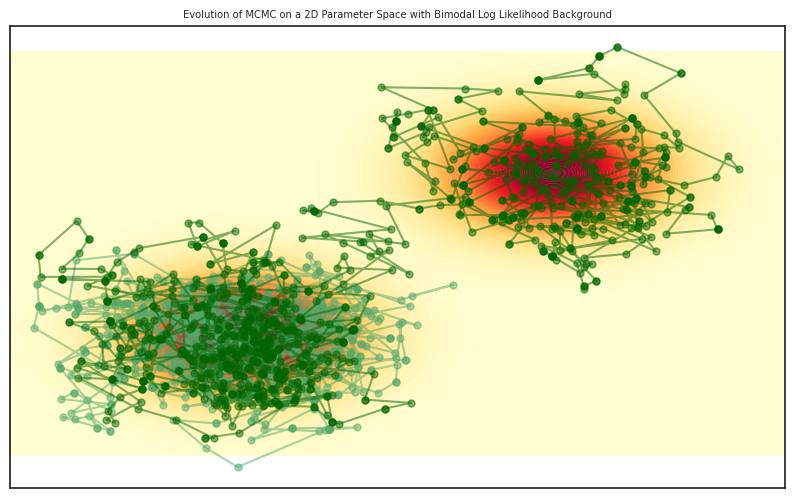

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# Define the target distribution (a bimodal 2D Gaussian)
def target_distribution(x, y):
    return (np.exp(-0.5 * ((x - 2)**2 + (y - 2)**2)) + np.exp(-0.5 * ((x + 2)**2 + (y + 2)**2)))#+ np.random.normal(0, 0.02)

# Metropolis-Hastings MCMC
def metropolis_hastings(num_samples, proposal_width):
    samples = np.zeros((num_samples, 2))
    x, y = 0, 0  # Start at the origin
    for i in range(num_samples):
        x_new = x + np.random.normal(0, proposal_width)
        y_new = y + np.random.normal(0, proposal_width)
        acceptance_ratio = target_distribution(x_new, y_new) / target_distribution(x, y)
        if np.random.rand() < acceptance_ratio:
            x, y = x_new, y_new
        samples[i] = [x, y]
    return samples

# Generate samples using MCMC
num_samples = 1000
proposal_width = 0.5
samples = metropolis_hastings(num_samples, proposal_width)
samples_2 = metropolis_hastings(num_samples, proposal_width)
samples_3 = metropolis_hastings(num_samples, proposal_width)

# Create a grid of points for the background
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = target_distribution(X, Y)

# Plot the evolution of the MCMC on a 2D parameter space with background
plt.figure(figsize=(10, 6))
plt.contourf(X, Y, Z, levels=100, cmap='YlOrRd', alpha=0.9)
plt.plot(samples[:, 0], samples[:, 1], 'o-', markersize=5, alpha=0.5,c='g')
plt.plot(samples_2[:, 0], samples_2[:, 1], 'o-', markersize=5, alpha=0.5,c="darkgreen")
#plt.plot(samples_3[:, 0], samples_3[:, 1], 'o-', markersize=2, alpha=0.5)
plt.title('Evolution of MCMC on a 2D Parameter Space with Bimodal Log Likelihood Background')
#plt.xlabel('Parameter 1')
#plt.ylabel('Parameter 2')
# make the x labels and numbers disappear
plt.xticks([])
plt.yticks([])

#plt.colorbar(label='Log Likelihood')
plt.grid(False)
# Save the figure as an SVG file with high resolution
plt.savefig('notebook/figures/MCMC_2D_Bimodal.svg', format='svg', bbox_inches='tight')



In [55]:
filename  =( "/run/user/1000/gvfs/sftp:host=lcmdlc3.epfl.ch,user=mazzouzi/home/mazzouzi/pl_temp_fit/fit_experimental_emcee_pl/fit_data/{config_folder}/ITIC-300K-2_G0_650.0nm_1450.0nm_12-07-2024-10h-44m_Exposure_3.0s_mod_split0_split500_mod_split0_split500/new_pl_sampling_alllifetimes_abs/"
    + "f1fbd365-fb8b-451c-961e-f2a8b58c68dd"
)

filename = filename+ "/sampler.h5"
reader = emcee.backends.HDFBackend(filename, name="multi_core")
distribution = reader.get_chain(discard=0, flat=True)

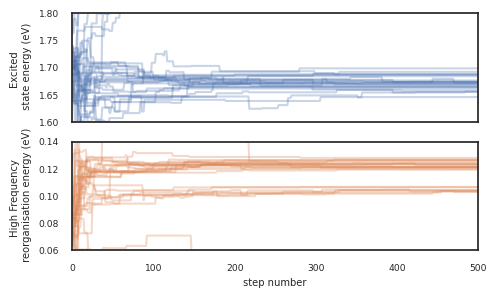

In [56]:
from pl_temp_fit import plot_utils
def plot_chains(reader, model_config_save, discard=50):
    """plot the chains from the sampling output
    reader: the reader object from the emcee sampler
    model_config_save: the model config save dictionary
    discard: the number of samples to discard
    """
    csv_name = model_config_save["csv_name_pl"]
    label_list = []
    for key in model_config_save["params_to_fit_init"].keys():
        label_list.extend(
            [
                key + "_" + x
                for x in model_config_save["params_to_fit_init"][key].keys()
            ]
        )
    params_to_fit = model_config_save["params_to_fit_init"] 
    labels = []
    min_bound = {}
    max_bound = {}
    for key in params_to_fit.keys():
        for keys in params_to_fit[key].keys():
            labels.append(f"{key}_{keys}")
            min_bound[f"{key}_{keys}"] = model_config_save["min_bounds"][key][keys]
            max_bound[f"{key}_{keys}"] = model_config_save["max_bounds"][key][keys]

    labels = label_list
    samples = reader.get_chain(discard=discard)[:500,:,[0,2]]
    fig, axes = plt.subplots(samples.shape[-1], figsize=(5, 1.5*samples.shape[-1]), sharex=True)
    ndim = 2#len(labels)
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], alpha=0.3, color="C" + str(i))
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
        if min_bound[labels[i]] is not None and max_bound[labels[i]] is not None:
            ax.set_ylim(min_bound[labels[i]], max_bound[labels[i]]) 

    axes[-1].set_xlabel("step number")
    #fig.suptitle(f"Sampler chain for {csv_name.split('/')[-1]}")
    fig.tight_layout()
    fig.show()
    return fig, axes
fig,axes = plot_chains(reader, model_config_save, discard=0)
axes[0].set_ylabel("Excited \n state energy (eV)")
axes[1].set_ylabel("High Frequency \n reorganisation energy (eV)")
axes[1].set_ylim(0.06, 0.14)
axes[0].set_ylim(1.6, 1.8)
fig.tight_layout()
fig.savefig("notebook/figures/chain_plot.svg")

Text(0.5, 1.0, 'Vibrational \n reorganisation energy (eV)')

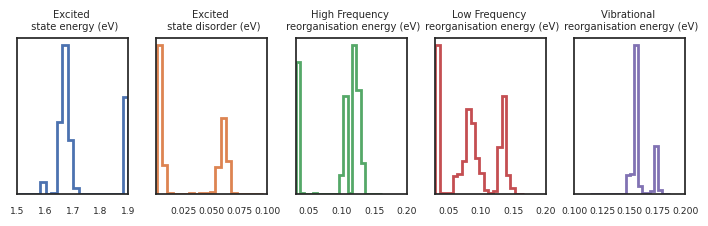

In [62]:
def plot_distribution(
    reader, model_config_save, discard=10, filter_log_likelihood="",
    fig=None,axes=None
):
    """plot the distribution of the parameters from the sampling output
    reader: the reader object from the emcee sampler
    model_config_save: the model config save dictionary
    discard: the number of samples to discard
    """
    csv_name = model_config_save["csv_name_pl"]
    min_bounds_list, max_bounds_list = [], []
    label_list = []
    for key in model_config_save["params_to_fit_init"].keys():
        label_list.extend(
            [
                key + "_" + x
                for x in model_config_save["params_to_fit_init"][key].keys()
            ]
        )
        min_bounds_list.extend(
            [
                model_config_save["min_bounds"][key][x]
                for x in model_config_save["params_to_fit_init"][key].keys()
            ]
        )
        max_bounds_list.extend(
            [
                model_config_save["max_bounds"][key][x]
                for x in model_config_save["params_to_fit_init"][key].keys()    
            ]
        )

    labels = label_list
    ndim = len(labels)

    distribution = reader.get_chain(discard=discard, flat=True)
    blobs = reader.get_blobs(flat=True, discard=discard)
    distribution_plot = eval(f" distribution[{filter_log_likelihood}]")
    distribution_plot = distribution_plot.reshape(-1, ndim)
    if fig is None:
        fig, axes = plt.subplots(1,ndim, figsize=(7, 2))
    axes_xlim = [[x, y] for x, y in zip(min_bounds_list, max_bounds_list)]
    for i in range(ndim):
        ax = axes[i]
        ax.hist(
            distribution_plot[:, i],
            20,
            color="C" + str(i),
            linewidth=2,
            histtype="step",
            density=True,
            
        )
        #ax.set_ylabel(labels[i])
        ax.set_yticks([])
        ax.set_xlim(axes_xlim[i])
    #fig.suptitle(f"Sampler distribution for {csv_name.split('/')[-1]}")
    fig.tight_layout()
    return fig, axes
fig,ax = plot_distribution(reader, model_config_save, discard=0, filter_log_likelihood=True)
ax[0].set_title("Excited \n state energy (eV)")
ax[1].set_title("Excited \n state disorder (eV)")
ax[2].set_title("High Frequency \n reorganisation energy (eV)")
#ax[2].set_xlim(0.06, 0.08)
#ax[3].set_xlim(0.06, 0.12)
ax[3].set_title("Low Frequency \n reorganisation energy (eV)")
ax[4].set_title("Vibrational \n reorganisation energy (eV)")


In [63]:
ax[0].set_title("Excited \n state energy (eV)")
ax[1].set_title("Excited \n state disorder (eV)")
ax[2].set_title("High Frequency \n reorganisation energy (eV)")
ax[2].set_xlim(0.06, 0.14)
ax[3].set_xlim(0.06, 0.16)
ax[3].set_title("Low Frequency \n reorganisation energy (eV)")
ax[4].set_title("Vibrational \n reorganisation energy (eV)")
fig.savefig("notebook/figures/distribution_plot.svg")

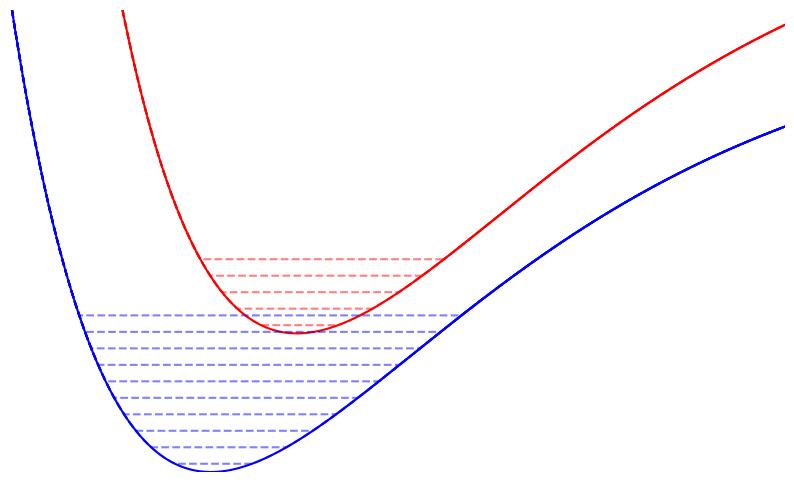

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Morse potential function
def morse_potential(r, D_e, a, r_e):
    return D_e * (1 - np.exp(-a * (r - r_e)))**2 - D_e

# Parameters for the first Morse potential
D_e1 =5
a1 = 1
r_e1 = 1.0

# Parameters for the second Morse potential
D_e2 = 5
a2 = 1
r_e2 = 1.0

# Range of r values
r = np.linspace(0, 3, 400)

# Calculate Morse potentials
V1 = morse_potential(r, D_e1, a1, r_e1)
V2 = morse_potential(r, D_e2, a2, r_e2)

# Calculate vibronic modes for the first Morse potential
vibronic_modes_1 = [min(morse_potential(r, D_e1, a1, r_e1))*np.ones_like(r) + (n*0.1 + 0.05) * np.sqrt(2 * D_e1 * a1**2 / np.pi) for n in range(10)]

# Calculate vibronic modes for the second Morse potential
vibronic_modes_2 = [min(morse_potential(r, D_e2, a2, r_e2))*np.ones_like(r) + (n*0.1 + 0.05) * np.sqrt(2 * D_e2 * a2**2 / np.pi) for n in range(5)]

# take out vibronic modes out of the main morse potential
vibronic_modes_1 = [[max(x,y) for x,y in zip(v, V1)] for v in vibronic_modes_1]
vibronic_modes_2 = [[max(x,y) for x,y in zip(v, V2)] for v in vibronic_modes_2]
# Plot the Morse potentials and vibronic modes
plt.figure(figsize=(10, 6))
plt.plot(r, V1, label='Morse Potential 1 (a=1.0)', color='blue')
plt.plot(r+0.3, V2+1.5, label='Morse Potential 2 (a=0.5)', color='red')
# add sinuoidal vibronic modes


for i, mode in enumerate(vibronic_modes_1):
    plt.plot(r, mode, '--', color='blue', alpha=0.5)
    #plt.text(3.05, min(mode), f'v={i}', color='blue', verticalalignment='center')

for i, mode in enumerate(vibronic_modes_2):
    mode= np.array(mode)
    plt.plot(r+0.3, mode+1.5, '--', color='red', alpha=0.5)
    #plt.text(3.05, min(mode), f'v={i}', color='red', verticalalignment='center')

plt.grid(False)

#hide the x axis
plt.xticks([])
plt.yticks([])
#hide the outer frame
plt.box(False)
plt.ylim(-5, 0)
plt.xlim(0.3, 3)
plt.show()

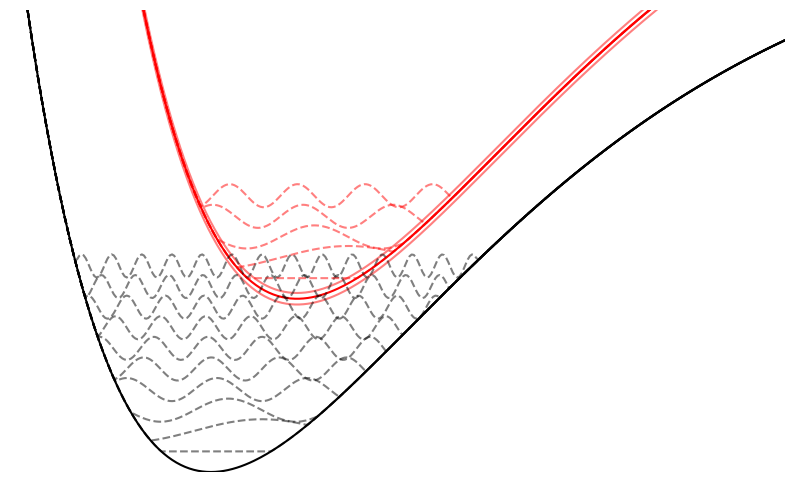

In [117]:
import numpy as np
import matplotlib.pyplot as plt

# Morse potential function
def morse_potential(r, D_e, a, r_e):
    return D_e * (1 - np.exp(-a * (r - r_e)))**2 - D_e

# Parameters for the first Morse potential
D_e1 = 5
a1 = 1
r_e1 = 1.0

# Parameters for the second Morse potential
D_e2 = 5
a2 = 1
r_e2 = 1.0

# Range of r values
r = np.linspace(0, 3, 400)

# Calculate Morse potentials
V1 = morse_potential(r, D_e1, a1, r_e1)
V2 = morse_potential(r, D_e2, a2, r_e2)

# Calculate vibronic modes for the first Morse potential
vibronic_modes_1 = [min(morse_potential(r, D_e1, a1, r_e1))*np.ones_like(r) + (n*0.1 + 0.1) * np.sqrt(2 * D_e1 * a1**2 / np.pi) for n in range(10)]

# Calculate vibronic modes for the second Morse potential
vibronic_modes_2 = [min(morse_potential(r, D_e2, a2, r_e2))*np.ones_like(r) + (n*0.1 + 0.1) * np.sqrt(2 * D_e2 * a2**2 / np.pi) for n in range(5)]

# Add sinusoidal variations to the vibronic modes
sinusoidal_amplitude = 0.1
s = np.linspace(0, 1, 10)*60

vibronic_modes_1 = [[max(y, x + sinusoidal_amplitude * np.sin(s[i] * r_i)) for x, y, r_i in zip(v, V1, r)] for i,v in enumerate(vibronic_modes_1)]
vibronic_modes_2 = [[max(y,x + sinusoidal_amplitude * np.sin(s[i] * r_i)) for x, y, r_i  in zip(v, V2, r)] for i,v in enumerate(vibronic_modes_2)]

# Plot the Morse potentials and vibronic modes
plt.figure(figsize=(10, 6))
plt.plot(r, V1, label='Morse Potential 1 (a=1.0)', color='black')
plt.plot(r + 0.3, V2 + 1.5, label='Morse Potential 2 (a=0.5)', color='red')
plt.plot(r + 0.3, V2 + 1.55, label='Morse Potential 2 (a=0.5)', color='red',alpha=0.5)
plt.plot(r + 0.3, V2 + 1.45, label='Morse Potential 2 (a=0.5)', color='red',alpha=0.5)


# Plot vibronic modes with sinusoidal variations
for i, mode in enumerate(vibronic_modes_1):
    plt.plot(r, mode, '--', color='black', alpha=0.5)

for i, mode in enumerate(vibronic_modes_2):
    mode = np.array(mode)
    plt.plot(r + 0.3, mode + 1.5, '--', color='red', alpha=0.5)


# Highlight overlap between vibronic modes
for i, mode1 in enumerate(vibronic_modes_1):
    for j, mode2 in enumerate(vibronic_modes_2):
        mode1 = np.array(mode1)
        mode2 = np.array(mode2)
        overlap = np.minimum(mode1, mode2 + 1.5)
        #plt.fill_between(r + 0.3, mode2 + 1.5, overlap, where=(overlap < mode2 + 1.5), color='purple', alpha=0.3)

plt.grid(False)

# Hide the x and y axis
plt.xticks([])
plt.yticks([])

# Hide the outer frame
plt.box(False)
plt.ylim(-5, -1)
plt.xlim(0.3, 3)
plt.savefig("figures/vibronic_modes.svg")
plt.show()

In [88]:
np.array(vibronic_modes_1)

array([[9.76246221, 9.41466609, 9.07357463, 8.73907644, 8.41106185,
        8.08942293, 7.77405342, 7.46484877, 7.16170602, 6.86452388],
       [9.76246221, 9.41466609, 9.07357463, 8.73907644, 8.41106185,
        8.08942293, 7.77405342, 7.46484877, 7.16170602, 6.86452388],
       [9.76246221, 9.41466609, 9.07357463, 8.73907644, 8.41106185,
        8.08942293, 7.77405342, 7.46484877, 7.16170602, 6.86452388],
       [9.76246221, 9.41466609, 9.07357463, 8.73907644, 8.41106185,
        8.08942293, 7.77405342, 7.46484877, 7.16170602, 6.86452388],
       [9.76246221, 9.41466609, 9.07357463, 8.73907644, 8.41106185,
        8.08942293, 7.77405342, 7.46484877, 7.16170602, 6.86452388],
       [9.76246221, 9.41466609, 9.07357463, 8.73907644, 8.41106185,
        8.08942293, 7.77405342, 7.46484877, 7.16170602, 6.86452388],
       [9.76246221, 9.41466609, 9.07357463, 8.73907644, 8.41106185,
        8.08942293, 7.77405342, 7.46484877, 7.16170602, 6.86452388],
       [9.76246221, 9.41466609, 9.0735746